# Capstone: West Nile Virus

![chicago](images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
#import plotly

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Load Datasets & feature selection

In [2]:
datadir = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

In [3]:
''' load the datasets '''

# load the main datasets that contain virus test results
train = pd.read_csv(os.path.join(datadir_pr, 'train_cleaned.csv'), parse_dates=['Date'], index_col='Date')
test = pd.read_csv(os.path.join(datadir_pr, 'test_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the weather data
weather = pd.read_csv(os.path.join(datadir_pr, 'weather_cleaned.csv'), parse_dates=['Date'], index_col='Date')

# load the spraying data
spray = pd.read_csv(os.path.join(datadir_pr,'spray_cleaned.csv'), parse_dates=['DateTime'], index_col='DateTime')

# load the map data
mapdata = np.loadtxt(os.path.join(datadir,"mapdata_copyright_openstreetmap_contributors.txt"))
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

In [4]:
train.head(3)

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Latitude2,Longitude2
Date,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,41.95,-87.80
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,41.95,-87.80
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,41.99,-87.77


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
 11  Latitude2               10506 non-null  float64
 12  Longitude2              10506 non-null  float64
dtypes: float64(4), int64(4), object(5)
memory usage: 1.1+ MB


In [6]:
# drop address (and location) columns
col_drop = ['Address', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'Latitude2','Longitude2']
train_selected = train.drop(col_drop, axis=1)
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Species          10506 non-null  object
 1   Block            10506 non-null  int64 
 2   AddressAccuracy  10506 non-null  int64 
 3   NumMosquitos     10506 non-null  int64 
 4   WnvPresent       10506 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 492.5+ KB


In [7]:
''' 'NumMosquitos' & 'WnvPresent' are target data 
    We will choose either of targets when it splits by train_test '''

col_targets = ['NumMosquitos', 'WnvPresent']
targets = train_selected[['NumMosquitos', 'WnvPresent']]
train_selected = train_selected.drop(col_targets, axis=1)
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Species          10506 non-null  object
 1   Block            10506 non-null  int64 
 2   AddressAccuracy  10506 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 328.3+ KB


In [8]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NumMosquitos  10506 non-null  int64
 1   WnvPresent    10506 non-null  int64
dtypes: int64(2)
memory usage: 246.2 KB


### One-hot code for Species in Train dataset

In [9]:
train_selected = pd.get_dummies(train_selected, columns=['Species'], prefix='Species')
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Block                           10506 non-null  int64
 1   AddressAccuracy                 10506 non-null  int64
 2   Species_CULEX ERRATICUS         10506 non-null  uint8
 3   Species_CULEX PIPIENS           10506 non-null  uint8
 4   Species_CULEX PIPIENS/RESTUANS  10506 non-null  uint8
 5   Species_CULEX RESTUANS          10506 non-null  uint8
 6   Species_CULEX SALINARIUS        10506 non-null  uint8
 7   Species_CULEX TARSALIS          10506 non-null  uint8
 8   Species_CULEX TERRITANS         10506 non-null  uint8
dtypes: int64(2), uint8(7)
memory usage: 318.1 KB


In [10]:
''' In EDA process, we checked that only Culex Pipiens, Culex Restuans species carry the virus.
    So, the rest should be removed '''

drop_col = ['Species_CULEX ERRATICUS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', \
           'Species_CULEX TERRITANS', 'Species_CULEX PIPIENS/RESTUANS']
# note that 'Species_CULEX PIPIENS/RESTUANS' is also removed as this can be identified by other two features (e.g., Pipiens=0, Restuans=0 then Pipines/Restuans=1)
train_selected.drop(drop_col, axis=1, inplace=True)
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Block                   10506 non-null  int64
 1   AddressAccuracy         10506 non-null  int64
 2   Species_CULEX PIPIENS   10506 non-null  uint8
 3   Species_CULEX RESTUANS  10506 non-null  uint8
dtypes: int64(2), uint8(2)
memory usage: 266.8 KB


In [11]:
train_selected.head(3)

,Block,AddressAccuracy,Species_CULEX PIPIENS,Species_CULEX RESTUANS
Date,,,,
2007-05-29,41,9,0,0
2007-05-29,41,9,0,1
2007-05-29,62,9,0,1


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Address                 116293 non-null  object 
 2   Species                 116293 non-null  object 
 3   Block                   116293 non-null  int64  
 4   Street                  116293 non-null  object 
 5   Trap                    116293 non-null  object 
 6   AddressNumberAndStreet  116293 non-null  object 
 7   Latitude                116293 non-null  float64
 8   Longitude               116293 non-null  float64
 9   AddressAccuracy         116293 non-null  int64  
 10  Latitude2               116293 non-null  float64
 11  Longitude2              116293 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 11.5+ MB


In [13]:
# drop address (and location) columns
col_drop = ['Id', 'Address', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'Latitude2','Longitude2']

test_selected = test.drop(col_drop, axis=1)

In [14]:
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Species          116293 non-null  object
 1   Block            116293 non-null  int64 
 2   AddressAccuracy  116293 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ MB


### One-hot code for Species in test dataset

In [15]:
test_selected = pd.get_dummies(test_selected, columns=['Species'], prefix='Species')
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   Block                           116293 non-null  int64
 1   AddressAccuracy                 116293 non-null  int64
 2   Species_CULEX ERRATICUS         116293 non-null  uint8
 3   Species_CULEX PIPIENS           116293 non-null  uint8
 4   Species_CULEX PIPIENS/RESTUANS  116293 non-null  uint8
 5   Species_CULEX RESTUANS          116293 non-null  uint8
 6   Species_CULEX SALINARIUS        116293 non-null  uint8
 7   Species_CULEX TARSALIS          116293 non-null  uint8
 8   Species_CULEX TERRITANS         116293 non-null  uint8
 9   Species_UNSPECIFIED CULEX       116293 non-null  uint8
dtypes: int64(2), uint8(8)
memory usage: 3.5 MB


In [16]:
''' In EDA process, we checked that only Culex Pipiens, Culex Restuans species carry the virus.
    So, the rest should be removed '''

drop_col = ['Species_CULEX ERRATICUS', 'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', \
           'Species_CULEX TERRITANS', 'Species_CULEX PIPIENS/RESTUANS']
# note that 'Species_CULEX PIPIENS/RESTUANS' is also removed as this can be identified by other two features (e.g., Pipiens=0, Restuans=0 then Pipines/Restuans=1)
test_selected.drop(drop_col, axis=1, inplace=True)
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   Block                      116293 non-null  int64
 1   AddressAccuracy            116293 non-null  int64
 2   Species_CULEX PIPIENS      116293 non-null  uint8
 3   Species_CULEX RESTUANS     116293 non-null  uint8
 4   Species_UNSPECIFIED CULEX  116293 non-null  uint8
dtypes: int64(2), uint8(3)
memory usage: 3.0 MB


<div class='alert alert-warning'>
Note:

- there are Unspecified species in test dataset. They will be removed for now.
</div>

In [17]:
''' Remove unspecified mosquitos '''

test_selected = test_selected.loc[test_selected['Species_UNSPECIFIED CULEX'] == 0,:]
test_selected.drop('Species_UNSPECIFIED CULEX', axis=1, inplace=True)

In [18]:
test_selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101948 entries, 2008-06-11 to 2014-10-02
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Block                   101948 non-null  int64
 1   AddressAccuracy         101948 non-null  int64
 2   Species_CULEX PIPIENS   101948 non-null  uint8
 3   Species_CULEX RESTUANS  101948 non-null  uint8
dtypes: int64(2), uint8(2)
memory usage: 2.5 MB


In [19]:
test_selected.head(3)

,Block,AddressAccuracy,Species_CULEX PIPIENS,Species_CULEX RESTUANS
Date,,,,
2008-06-11,41,9,0,0
2008-06-11,41,9,0,1
2008-06-11,41,9,1,0


### Split Weather data by two stations

In [20]:
weather.head(3)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,1849.0,,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,14.0,51,57.0,0.0,3.0,448.0,1849.0,,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,1850.0,BR,0.0,0.0,29.38,30.09,13.0,4,13.4


In [21]:
weather_stn1 = weather[weather.Station == 1].drop('Station', axis=1)
weather_stn2 = weather[weather.Station == 2].drop('Station', axis=1)

In [22]:
weather_stn1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   object 
 11  SnowFall     1472 non-null   float64
 12  PrecipTotal  1472 non-null   float64
 13  StnPressure  1472 non-null   float64
 14  SeaLevel     1472 non-null   float64
 15  ResultSpeed  1472 non-null   float64
 16  ResultDir    1472 non-null   int64  
 17  AvgSpeed     1472 non-null   float64
dtypes: float64(13), int64(4), obje

In [23]:
weather_stn2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  CodeSum      1472 non-null   object 
 11  SnowFall     1472 non-null   float64
 12  PrecipTotal  1472 non-null   float64
 13  StnPressure  1472 non-null   float64
 14  SeaLevel     1472 non-null   float64
 15  ResultSpeed  1472 non-null   float64
 16  ResultDir    1472 non-null   int64  
 17  AvgSpeed     1472 non-null   float64
dtypes: float64(13), int64(4), obje

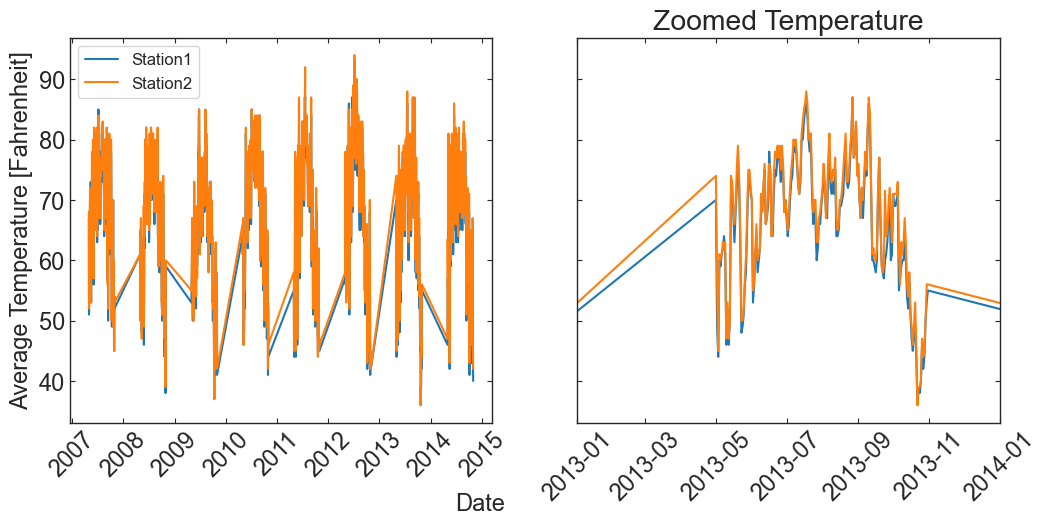

In [24]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True)

axes[0].plot(weather_stn1.index, weather_stn1.Tavg, label='Station1')
axes[0].plot(weather_stn2.index, weather_stn2.Tavg, label='Station2')
#plt.locator_params(axis='x', nbins=1)
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_ylabel('Average Temperature [Fahrenheit]')
axes[0].legend(loc='upper left', fontsize=12)

axes[1].plot(weather_stn1.index, weather_stn1.Tavg)
axes[1].plot(weather_stn2.index, weather_stn2.Tavg)
axes[1].set_xlim(datetime.date(2013,1,1), datetime.date(2014,1,1))
axes[1].tick_params(axis='x',labelrotation=45)
axes[1].set_title('Zoomed Temperature')

axes[1].annotate('Date', (0.4,0.01), xycoords='figure fraction', ha='center');

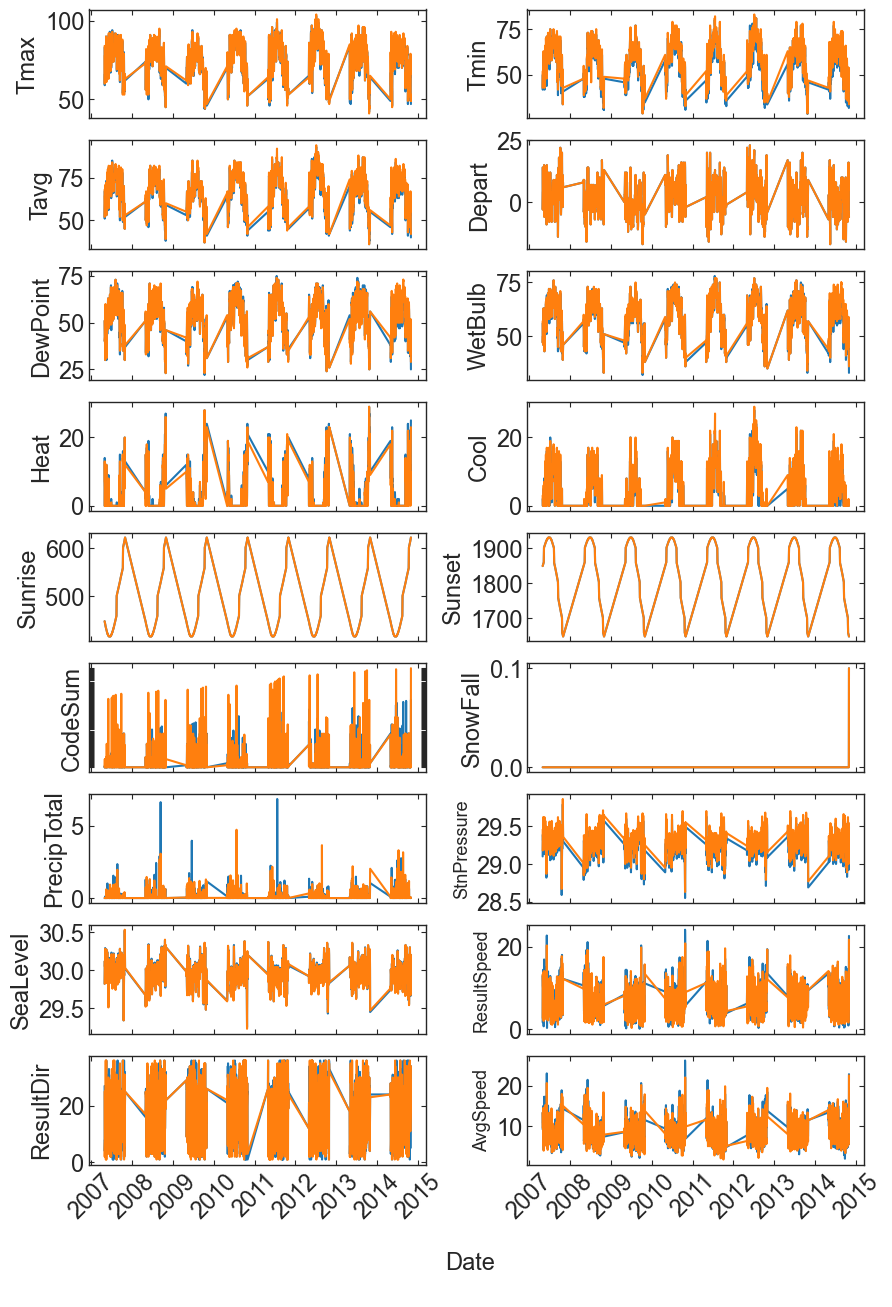

In [25]:
ncols = len(weather_stn1.columns) # number of total columns
ncol_win = 2
fig, axes = plt.subplots(int(ncols/ncol_win), ncol_win, figsize=(10,15), sharex=True)

for icol, iax in zip(weather_stn1.columns, axes.ravel()):
    iax.plot(weather_stn1.index, weather_stn1[icol], label='Stn1')
    iax.plot(weather_stn2.index, weather_stn2[icol], label='Stn2')
    iax.tick_params(axis='x',labelrotation=45)
    
    if icol=='CodeSum':
        iax.tick_params(axis='y',label1On=False)
    if icol in ['StnPressure','ResultSpeed','AvgSpeed']:
        iax.set_ylabel(icol, fontsize=13)
    else: iax.set_ylabel(icol)

axes[0,0].annotate('Date', (0.47,0.025), xycoords='figure fraction', ha='center');
fig.subplots_adjust(wspace=0.3)

In [26]:
weather_stn1.describe().T

,count,mean,std,min,25%,50%,75%,max
Tmax,1472.0,75.978940,11.503150,42.00,68.00,78.000,85.00,103.00
Tmin,1472.0,56.730978,10.347907,29.00,49.00,58.000,65.00,82.00
Tavg,1472.0,66.606658,10.511437,36.00,60.00,68.000,75.00,93.00
Depart,1472.0,1.954484,6.841110,-17.00,-3.00,2.000,7.00,23.00
DewPoint,1472.0,53.377717,10.670263,22.00,46.00,54.000,61.25,75.00
WetBulb,1472.0,59.052310,9.323150,32.00,53.00,60.000,66.00,78.00
Heat,1472.0,3.631114,6.133829,0.00,0.00,0.000,5.00,29.00
Cool,1472.0,5.237772,5.899382,0.00,0.00,3.000,10.00,28.00
Sunrise,1472.0,480.646739,65.344729,416.00,424.75,446.500,531.25,623.00
Sunset,1472.0,1847.347826,87.050615,1647.00,1792.25,1859.500,1922.25,1931.00


In [27]:
weather_stn2.describe().T

,count,mean,std,min,25%,50%,75%,max
Tmax,1472.0,76.353261,11.421482,41.00,69.000,78.00,85.000,104.00
Tmin,1472.0,58.889946,10.306855,29.00,51.000,60.00,67.000,83.00
Tavg,1472.0,67.871943,10.531672,36.00,61.000,70.00,76.000,94.00
Depart,1472.0,1.954484,6.841110,-17.00,-3.000,2.00,7.000,23.00
DewPoint,1472.0,53.538043,10.683121,23.00,46.000,55.00,62.000,74.00
WetBulb,1472.0,59.591033,9.244169,33.00,53.000,61.00,67.000,77.00
Heat,1472.0,3.204484,5.765144,0.00,0.000,0.00,4.000,29.00
Cool,1472.0,6.044837,6.279738,0.00,0.000,5.00,11.000,29.00
Sunrise,1472.0,480.646739,65.344729,416.00,424.750,446.50,531.250,623.00
Sunset,1472.0,1847.347826,87.050615,1647.00,1792.250,1859.50,1922.250,1931.00


<div class='alert alert-warning'>
Note:

- `SnowFall` feature seems unuseful as it has a single value only in 2015. So it would be better to drop it. 
- Evidently, the weather data between Staion1 and Station2 is quite similar to each other as they are closely located. Therefore, we will use the weather value from Station1 for now and the result will be tested with Station2 values later if needed.
   
</div>

In [28]:
''' Drop 'CodeSum' and 'SnowFall' features '''

drop_col = ['CodeSum', 'SnowFall']
weather_stn1.drop(drop_col, axis=1, inplace=True)
weather_stn2.drop(drop_col, axis=1, inplace=True)

In [29]:
weather_stn1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tmax         1472 non-null   int64  
 1   Tmin         1472 non-null   int64  
 2   Tavg         1472 non-null   float64
 3   Depart       1472 non-null   float64
 4   DewPoint     1472 non-null   int64  
 5   WetBulb      1472 non-null   float64
 6   Heat         1472 non-null   float64
 7   Cool         1472 non-null   float64
 8   Sunrise      1472 non-null   float64
 9   Sunset       1472 non-null   float64
 10  PrecipTotal  1472 non-null   float64
 11  StnPressure  1472 non-null   float64
 12  SeaLevel     1472 non-null   float64
 13  ResultSpeed  1472 non-null   float64
 14  ResultDir    1472 non-null   int64  
 15  AvgSpeed     1472 non-null   float64
dtypes: float64(12), int64(4)
memory usage: 195.5 KB


# Merging dataset (main + weather)
- We will use the weather data from Station1 for now.

In [30]:
train_merged = train_selected.join(weather_stn1, on='Date')
test_merged  = test_selected.join(weather_stn1, on='Date')

In [31]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   10506 non-null  int64  
 1   AddressAccuracy         10506 non-null  int64  
 2   Species_CULEX PIPIENS   10506 non-null  uint8  
 3   Species_CULEX RESTUANS  10506 non-null  uint8  
 4   Tmax                    10506 non-null  int64  
 5   Tmin                    10506 non-null  int64  
 6   Tavg                    10506 non-null  float64
 7   Depart                  10506 non-null  float64
 8   DewPoint                10506 non-null  int64  
 9   WetBulb                 10506 non-null  float64
 10  Heat                    10506 non-null  float64
 11  Cool                    10506 non-null  float64
 12  Sunrise                 10506 non-null  float64
 13  Sunset                  10506 non-null  float64
 14  PrecipTotal          

In [32]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101948 entries, 2008-06-11 to 2014-10-02
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Block                   101948 non-null  int64  
 1   AddressAccuracy         101948 non-null  int64  
 2   Species_CULEX PIPIENS   101948 non-null  uint8  
 3   Species_CULEX RESTUANS  101948 non-null  uint8  
 4   Tmax                    101948 non-null  int64  
 5   Tmin                    101948 non-null  int64  
 6   Tavg                    101948 non-null  float64
 7   Depart                  101948 non-null  float64
 8   DewPoint                101948 non-null  int64  
 9   WetBulb                 101948 non-null  float64
 10  Heat                    101948 non-null  float64
 11  Cool                    101948 non-null  float64
 12  Sunrise                 101948 non-null  float64
 13  Sunset                  101948 non-null  float64
 14  Prec

In [33]:
''' save the merged dataset '''

train_merged.to_csv(os.path.join(datadir_pr,'train_merged.csv'))
targets.to_csv(os.path.join(datadir_pr,'train_targets.csv'))
test_merged.to_csv(os.path.join(datadir_pr,'test_merged.csv'))

# Split the merged training data into train & test
- **NOTE** that the dataframe called `test` is new data which will be applied for the final outcome. This `test` dataset has no information of `WnvPresent` and `NumMosquitos`.
- train dataset will be splitted into tr_train and tr_test for building and testing a model

In [34]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(train_merged, targets.WnvPresent, test_size=0.3, random_state=23)

In [35]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_tr_train.sum()/len(y_tr_train)))
print('test:  {}'.format(y_tr_test.sum()/len(y_tr_test)))

Virus Positive ratio
train: 0.051944519989121564
test:  0.053616751269035534


In [36]:
X_tr_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7354 entries, 2009-07-13 to 2013-07-12
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   7354 non-null   int64  
 1   AddressAccuracy         7354 non-null   int64  
 2   Species_CULEX PIPIENS   7354 non-null   uint8  
 3   Species_CULEX RESTUANS  7354 non-null   uint8  
 4   Tmax                    7354 non-null   int64  
 5   Tmin                    7354 non-null   int64  
 6   Tavg                    7354 non-null   float64
 7   Depart                  7354 non-null   float64
 8   DewPoint                7354 non-null   int64  
 9   WetBulb                 7354 non-null   float64
 10  Heat                    7354 non-null   float64
 11  Cool                    7354 non-null   float64
 12  Sunrise                 7354 non-null   float64
 13  Sunset                  7354 non-null   float64
 14  PrecipTotal           

In [37]:
X_tr_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3152 entries, 2007-06-26 to 2013-08-08
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   3152 non-null   int64  
 1   AddressAccuracy         3152 non-null   int64  
 2   Species_CULEX PIPIENS   3152 non-null   uint8  
 3   Species_CULEX RESTUANS  3152 non-null   uint8  
 4   Tmax                    3152 non-null   int64  
 5   Tmin                    3152 non-null   int64  
 6   Tavg                    3152 non-null   float64
 7   Depart                  3152 non-null   float64
 8   DewPoint                3152 non-null   int64  
 9   WetBulb                 3152 non-null   float64
 10  Heat                    3152 non-null   float64
 11  Cool                    3152 non-null   float64
 12  Sunrise                 3152 non-null   float64
 13  Sunset                  3152 non-null   float64
 14  PrecipTotal           

In [38]:
y_tr_train.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7354 entries, 2009-07-13 to 2013-07-12
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
7354 non-null   int64
dtypes: int64(1)
memory usage: 114.9 KB


# Scaling

In [39]:
scaler = StandardScaler()
#scaler.fit(X_tr_train)
X_tr_train_scaled = scaler.fit_transform(X_tr_train)
X_tr_test_scaled  = scaler.transform(X_tr_test)

# Test Modeling 1: Logistic Regression

In [40]:
LogReg = LogisticRegression(solver='newton-cg', max_iter=1000)

In [41]:
LogReg.fit(X_tr_train_scaled, y_tr_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [42]:
y_tr_test_predict = LogReg.predict(X_tr_test_scaled)

In [43]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.9463832487309645


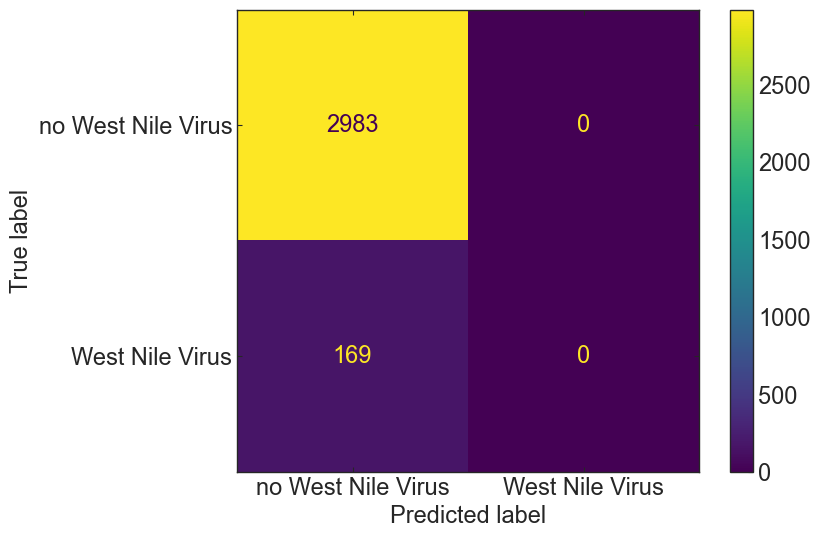

In [44]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

#ax.set_xticks([0, 1])
#ax.set_yticks([0, 1])
#ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
#ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8);

<div class='alert alert-danger'>
Note:
    
- Since the data is highly imbanaced, the first model with ***Logistic Regression*** was not successful.
</div>

# Test Modeling 2: Random Forest Classifier

In [45]:
Rand = RandomForestClassifier(random_state=42)

In [46]:
Rand.fit(X_tr_train_scaled, y_tr_train)

RandomForestClassifier(random_state=42)

In [47]:
y_tr_test_predict = Rand.predict(X_tr_test_scaled)

In [48]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.9273477157360406


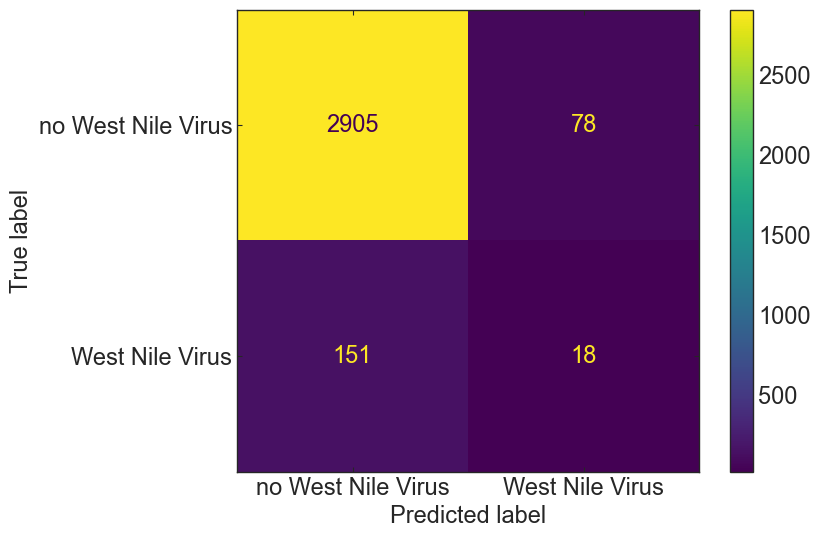

In [49]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

<div class='alert alert-danger'>
Note:
    
- The second model with ***Random Forest*** could detect some West Nile Virus, which is better than the result from the ***Logistic Regression***, but still the result is not good enough.
- We need to proceed over-sampling or under-sampling to resolve the problem with **imbalanced dataset**.
</div>

# Imbalanced Classification
- Oversampling for the minority feature (negative West Nile Virus)

In [50]:
print(Counter(targets.WnvPresent))

Counter({0: 9955, 1: 551})


In [51]:
# instantiating the random over sampler 
ros = RandomOverSampler()

# resampling X, y
X_ros, y_ros = ros.fit_resample(train_merged, targets.WnvPresent)

# new class distribution 
print(Counter(y_ros))

Counter({0: 9955, 1: 9955})


In [52]:
X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_ros, y_ros, test_size=0.3, random_state=23)

In [53]:
''' Check whether the data is equally splited '''
print('Virus Positive ratio')
print('train: {}'.format(y_tr_train.sum()/len(y_tr_train)))
print('test:  {}'.format(y_tr_test.sum()/len(y_tr_test)))

Virus Positive ratio
train: 0.4996053670086819
test:  0.5009208103130756


In [54]:
X_tr_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13937 entries, 13742 to 8787
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   13937 non-null  int64  
 1   AddressAccuracy         13937 non-null  int64  
 2   Species_CULEX PIPIENS   13937 non-null  uint8  
 3   Species_CULEX RESTUANS  13937 non-null  uint8  
 4   Tmax                    13937 non-null  int64  
 5   Tmin                    13937 non-null  int64  
 6   Tavg                    13937 non-null  float64
 7   Depart                  13937 non-null  float64
 8   DewPoint                13937 non-null  int64  
 9   WetBulb                 13937 non-null  float64
 10  Heat                    13937 non-null  float64
 11  Cool                    13937 non-null  float64
 12  Sunrise                 13937 non-null  float64
 13  Sunset                  13937 non-null  float64
 14  PrecipTotal             13937 non-n

In [55]:
X_tr_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5973 entries, 6553 to 2089
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Block                   5973 non-null   int64  
 1   AddressAccuracy         5973 non-null   int64  
 2   Species_CULEX PIPIENS   5973 non-null   uint8  
 3   Species_CULEX RESTUANS  5973 non-null   uint8  
 4   Tmax                    5973 non-null   int64  
 5   Tmin                    5973 non-null   int64  
 6   Tavg                    5973 non-null   float64
 7   Depart                  5973 non-null   float64
 8   DewPoint                5973 non-null   int64  
 9   WetBulb                 5973 non-null   float64
 10  Heat                    5973 non-null   float64
 11  Cool                    5973 non-null   float64
 12  Sunrise                 5973 non-null   float64
 13  Sunset                  5973 non-null   float64
 14  PrecipTotal             5973 non-null

In [56]:
y_tr_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 13937 entries, 13742 to 8787
Series name: WnvPresent
Non-Null Count  Dtype
--------------  -----
13937 non-null  int64
dtypes: int64(1)
memory usage: 217.8 KB


## Scaling

In [57]:
scaler = StandardScaler()
#scaler.fit(X_tr_train)
X_tr_train_scaled = scaler.fit_transform(X_tr_train)
X_tr_test_scaled  = scaler.transform(X_tr_test)

## Test Modeling with the balanced dataset: Logistic Regression

In [58]:
LogReg = LogisticRegression(solver='newton-cg', max_iter=1000)

In [59]:
LogReg.fit(X_tr_train_scaled, y_tr_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [60]:
y_tr_test_predict = LogReg.predict(X_tr_test_scaled)

In [61]:
print("Accuracy score (y_tr_test_predict, y_tr_test): {}".format(accuracy_score(y_tr_test_predict, y_tr_test)))

Accuracy score (y_tr_test_predict, y_tr_test): 0.6921145153189352


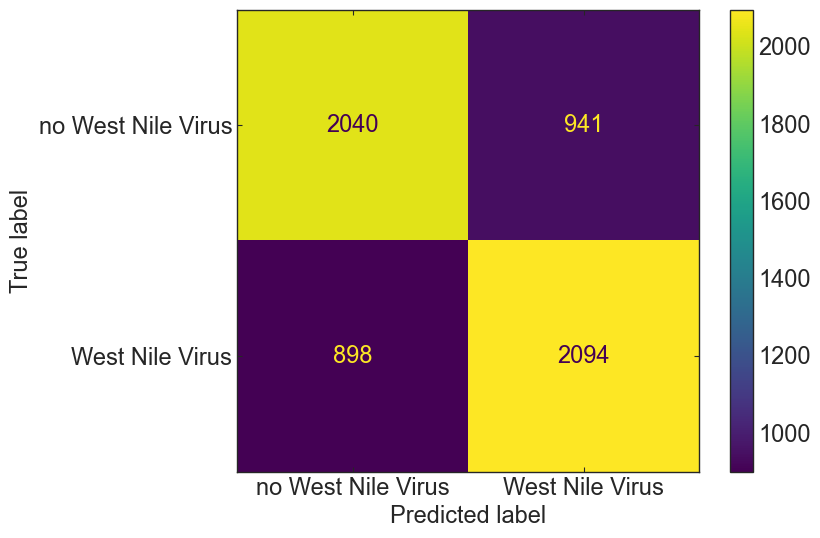

In [62]:
''' plot the confusion matrix '''
cm = confusion_matrix(y_tr_test, y_tr_test_predict, labels = LogReg.classes_)
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no West Nile Virus', 'West Nile Virus'])
fig, ax = plt.subplots()
display_cm.plot(ax=ax);

> - Now we could see that the model is greatly improved, and the balanced dataset is ready for building the models.
> - We will develop several models in the next step, and check the statistics and diagnostics like Receiver Operating Characteristics curve to find the best-bet one.

# Conclusion

In this preprocessing and feature engineering process, 
- re-checked the dataset and selected features of interest
- re-organized the categorical features by using one-hot code
- merged two separate datasets into one which would be used for modeling
- splitted the dataset into trainning and test ones 
- re-scaled (standardized) the dataset.

We found that the number of West Nile Virus positive cases is significantly smaller than that of negative cases (**Imblanced Classification**), the additional balancing process is demanded. 